In [ ]:
#%%

#
#  60/40 portfolio on raw proxies
#  SPY for the stocks
#  AGG for the bonds
#

import warnings
warnings.filterwarnings("ignore")
def action_with_warnings():
    warnings.warn("should not appear")
with warnings.catch_warnings(record=True):
    action_with_warnings()
import norgatedata
import quantstats        as qs
import pandas            as pd
import numpy             as np
import matplotlib.pyplot as plt

[2024-04-18 08:49:46.093280] INFO: Norgate Data: NorgateData package v1.0.74: Init complete


In [ ]:
#%%

# Preparing data using Norgate

# Stocks
spy_df = norgatedata.price_timeseries(
    "SPY",
    stock_price_adjustment_setting = norgatedata.StockPriceAdjustmentType.TOTALRETURN,
    padding_setting                = norgatedata.PaddingType.NONE,
    start_date                     = "1990-01-01",
    timeseriesformat               = 'pandas-dataframe',
)

df = pd.DataFrame(index=spy_df.index)
df['SPY'] = spy_df['Close']

# Bonds
agg_df = norgatedata.price_timeseries(
    "AGG",
    stock_price_adjustment_setting = norgatedata.StockPriceAdjustmentType.TOTALRETURN,
    padding_setting                = norgatedata.PaddingType.NONE,
    start_date                     = "1990-01-01",
    timeseriesformat               = 'pandas-dataframe',
)

df['AGG'] = agg_df['Close']

df

,SPY,AGG
Date,,
1993-01-29,24.707020,NaN
1993-02-01,24.847401,NaN
1993-02-02,24.917591,NaN
1993-02-03,25.128162,NaN
1993-02-04,25.268543,NaN
...,...,...
2024-04-11,518.000000,95.779999
2024-04-12,510.850006,95.959999
2024-04-15,504.450012,95.379997


In [ ]:
#%%

df.dropna(inplace=True)

df

,SPY,AGG
Date,,
2003-09-26,67.640236,54.015850
2003-09-29,68.303444,53.868225
2003-09-30,67.640236,54.147659
2003-10-01,69.081696,54.121300
2003-10-02,69.332092,54.036942
...,...,...
2024-04-11,518.000000,95.779999
2024-04-12,510.850006,95.959999
2024-04-15,504.450012,95.379997


<Axes: xlabel='Date'>

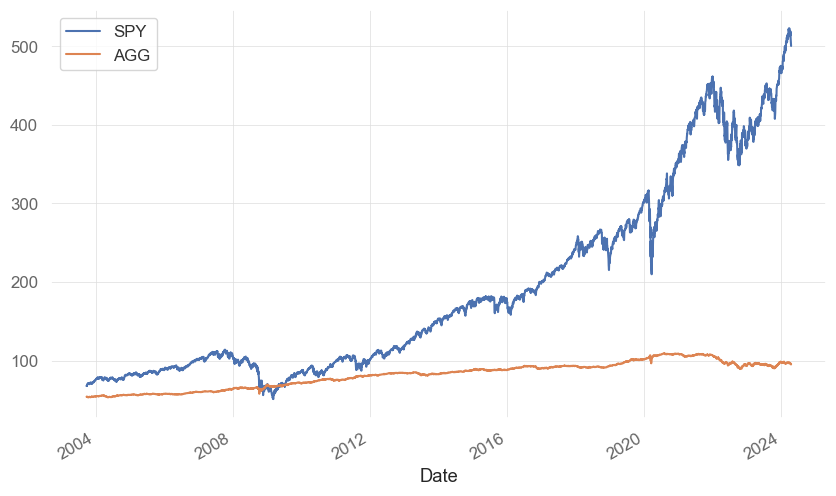

In [ ]:
#%%

df[['SPY', 'AGG']].plot()

<Axes: xlabel='Date'>

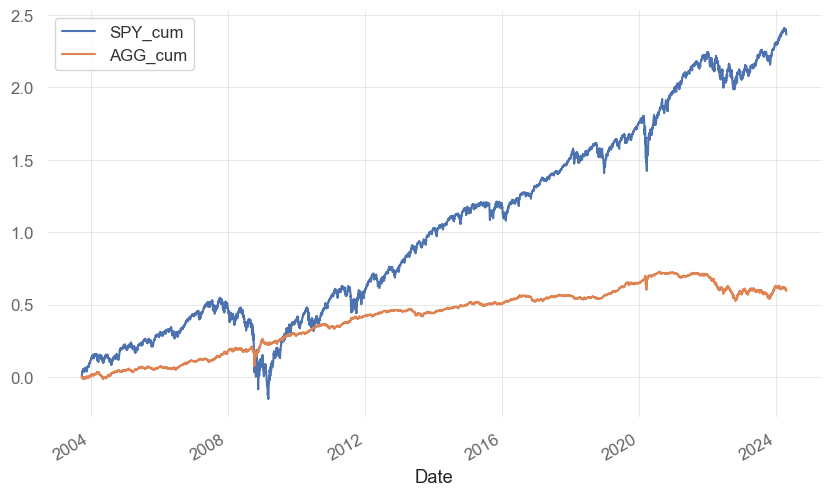

In [ ]:
#%%

df['SPY_ret'] = df['SPY'    ].pct_change()
df['AGG_ret'] = df['AGG'    ].pct_change()
df['SPY_cum'] = df['SPY_ret'].cumsum()
df['AGG_cum'] = df['AGG_ret'].cumsum()

df[['SPY_cum', 'AGG_cum']].plot()

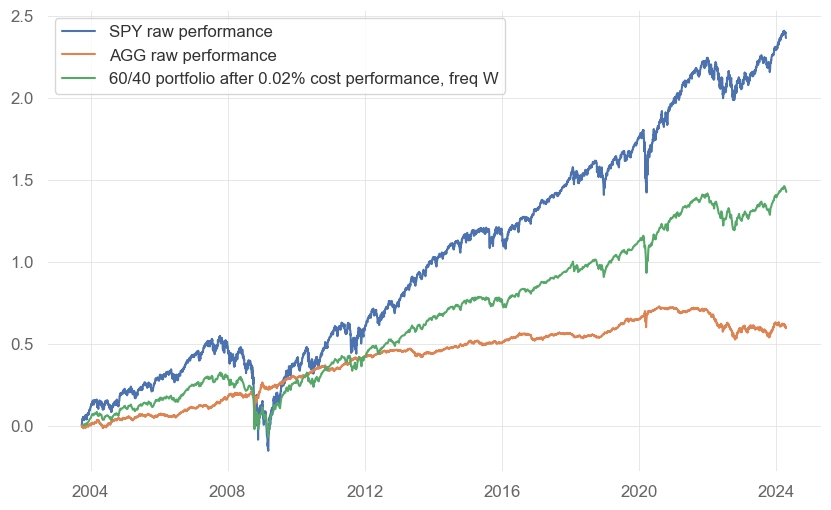

In [ ]:
#%%

# 2 BPS for trading cost proxy using Interactive Brokers fee model, very optimistic
rebalancing_cost        = 0.02/100.0
rebalancing_cost_log    = np.log(1-rebalancing_cost)

previous_rebalance_date = None
rebalance_frequency     = 'W' # rebalancing frequency
stock_weight            = 0.6
bond_weight             = 0.4
portfolio_dates         = []
portfolio_returns       = []

for date, group in df.groupby(pd.Grouper(freq=rebalance_frequency)):
    group_df = group.copy()
    group_df['SPY_freq_cum'] = group_df['SPY_ret'].cumsum()
    group_df['AGG_freq_cum'] = group_df['AGG_ret'].cumsum()
    return_at_rebalance = stock_weight * group_df.iloc[-1]['SPY_freq_cum'] + bond_weight * group_df.iloc[-1]['AGG_freq_cum']
    portfolio_dates.append(date)
    portfolio_returns.append(return_at_rebalance)

portfolio_df = pd.DataFrame(index=portfolio_dates)
portfolio_df.index = pd.to_datetime(portfolio_df.index)
portfolio_df['ret'             ] = portfolio_returns
portfolio_df['log_ret'         ] = (1+portfolio_df['ret']).apply(np.log)
portfolio_df['adjusted_log_ret'] = portfolio_df['log_ret'] + rebalancing_cost_log
portfolio_df['cum'             ] = portfolio_df['log_ret'].cumsum().apply(np.exp)
portfolio_df['adjusted_cum'    ] = portfolio_df['adjusted_log_ret'].cumsum().apply(np.exp)
portfolio_df['adjusted_ret'    ] = portfolio_df['adjusted_cum'].pct_change()

plt.plot(df['SPY_cum'])
plt.plot(df['AGG_cum'])
plt.plot(portfolio_df['adjusted_ret'].cumsum())
plt.legend(['SPY raw performance', 'AGG raw performance', f"60/40 portfolio after {round(rebalancing_cost*100.0, 2)}% cost performance, freq {rebalance_frequency}"])
plt.show()

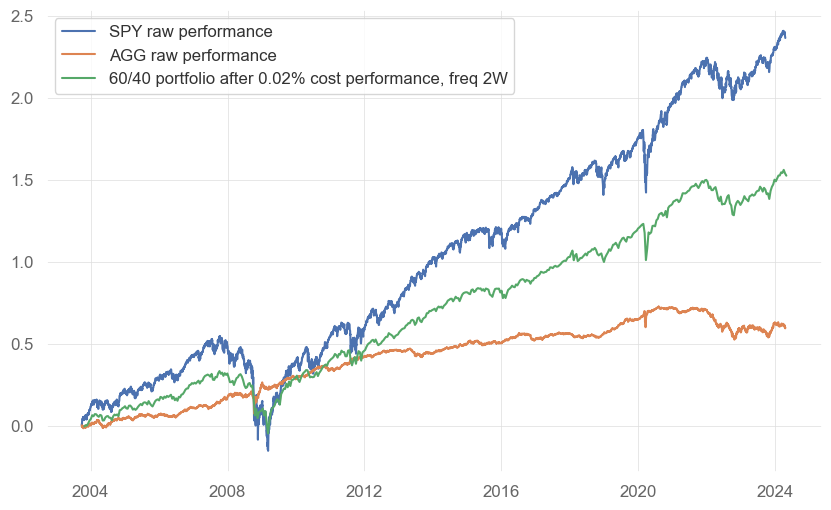

In [ ]:
#%%

# 2 BPS for trading cost proxy using Interactive Brokers fee model, very optimistic
rebalancing_cost        = 0.02/100.0
rebalancing_cost_log    = np.log(1-rebalancing_cost)

previous_rebalance_date = None
rebalance_frequency     = '2W' # rebalancing frequency
stock_weight            = 0.6
bond_weight             = 0.4
portfolio_dates         = []
portfolio_returns       = []

for date, group in df.groupby(pd.Grouper(freq=rebalance_frequency)):
    group_df = group.copy()
    group_df['SPY_freq_cum'] = group_df['SPY_ret'].cumsum()
    group_df['AGG_freq_cum'] = group_df['AGG_ret'].cumsum()
    return_at_rebalance = stock_weight * group_df.iloc[-1]['SPY_freq_cum'] + bond_weight * group_df.iloc[-1]['AGG_freq_cum']
    portfolio_dates.append(date)
    portfolio_returns.append(return_at_rebalance)

portfolio_df = pd.DataFrame(index=portfolio_dates)
portfolio_df.index = pd.to_datetime(portfolio_df.index)
portfolio_df['ret'             ] = portfolio_returns
portfolio_df['log_ret'         ] = (1+portfolio_df['ret']).apply(np.log)
portfolio_df['adjusted_log_ret'] = portfolio_df['log_ret'] + rebalancing_cost_log
portfolio_df['cum'             ] = portfolio_df['log_ret'].cumsum().apply(np.exp)
portfolio_df['adjusted_cum'    ] = portfolio_df['adjusted_log_ret'].cumsum().apply(np.exp)
portfolio_df['adjusted_ret'    ] = portfolio_df['adjusted_cum'].pct_change()

plt.plot(df['SPY_cum'])
plt.plot(df['AGG_cum'])
plt.plot(portfolio_df['adjusted_ret'].cumsum())
plt.legend(['SPY raw performance', 'AGG raw performance', f"60/40 portfolio after {round(rebalancing_cost*100.0, 2)}% cost performance, freq {rebalance_frequency}"])
plt.show()

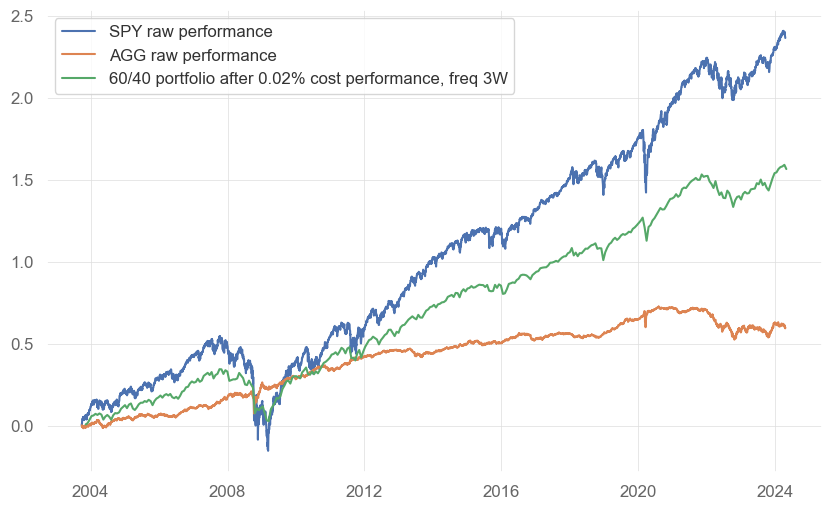

In [ ]:
#%%

# 2 BPS for trading cost proxy using Interactive Brokers fee model, very optimistic
rebalancing_cost        = 0.02/100.0
rebalancing_cost_log    = np.log(1-rebalancing_cost)

previous_rebalance_date = None
rebalance_frequency     = '3W' # rebalancing frequency
stock_weight            = 0.6
bond_weight             = 0.4
portfolio_dates         = []
portfolio_returns       = []

for date, group in df.groupby(pd.Grouper(freq=rebalance_frequency)):
    group_df = group.copy()
    group_df['SPY_freq_cum'] = group_df['SPY_ret'].cumsum()
    group_df['AGG_freq_cum'] = group_df['AGG_ret'].cumsum()
    return_at_rebalance = stock_weight * group_df.iloc[-1]['SPY_freq_cum'] + bond_weight * group_df.iloc[-1]['AGG_freq_cum']
    portfolio_dates.append(date)
    portfolio_returns.append(return_at_rebalance)

portfolio_df = pd.DataFrame(index=portfolio_dates)
portfolio_df.index = pd.to_datetime(portfolio_df.index)
portfolio_df['ret'             ] = portfolio_returns
portfolio_df['log_ret'         ] = (1+portfolio_df['ret']).apply(np.log)
portfolio_df['adjusted_log_ret'] = portfolio_df['log_ret'] + rebalancing_cost_log
portfolio_df['cum'             ] = portfolio_df['log_ret'].cumsum().apply(np.exp)
portfolio_df['adjusted_cum'    ] = portfolio_df['adjusted_log_ret'].cumsum().apply(np.exp)
portfolio_df['adjusted_ret'    ] = portfolio_df['adjusted_cum'].pct_change()

plt.plot(df['SPY_cum'])
plt.plot(df['AGG_cum'])
plt.plot(portfolio_df['adjusted_ret'].cumsum())
plt.legend(['SPY raw performance', 'AGG raw performance', f"60/40 portfolio after {round(rebalancing_cost*100.0, 2)}% cost performance, freq {rebalance_frequency}"])
plt.show()

In [ ]:
#%%

qs.stats.sharpe(portfolio_df['adjusted_ret'])

3.089060941265621

                           Strategy
-------------------------  ----------
Start Period               2003-11-09
End Period                 2024-04-28
Risk-Free Rate             0.0%
Time in Market             100.0%

Cumulative Return          335.39%
CAGR﹪                     5.08%

Sharpe                     3.1
Prob. Sharpe Ratio         99.92%
Smart Sharpe               2.99
Sortino                    4.29
Smart Sortino              4.14
Sortino/√2                 3.03
Smart Sortino/√2           2.92
Omega                      1.69

Max Drawdown               -28.73%
Longest DD Days            1072
Volatility (ann.)          35.68%
Calmar                     0.18
Skew                       -1.56
Kurtosis                   8.12

Expected Daily %           0.41%
Expected Monthly %         0.6%
Expected Yearly %          6.92%
Kelly Criterion            27.72%
Risk of Ruin               0.0%
Daily Value-at-Risk        -3.26%
Expected Shortfall (cVaR)  -3.26%

Max Consecutive Wins     

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2007-10-28,2009-03-15,2010-10-03,1072,-28.726721,-28.256947
2,2021-11-28,2022-10-09,2024-01-14,778,-18.616775,-15.313066
3,2020-03-08,2020-03-29,2020-06-21,106,-13.613988,-6.363150
4,2018-10-21,2018-12-23,2019-03-17,148,-10.046785,-5.716529
5,2011-08-14,2011-09-25,2012-01-08,148,-7.939770,-6.681334


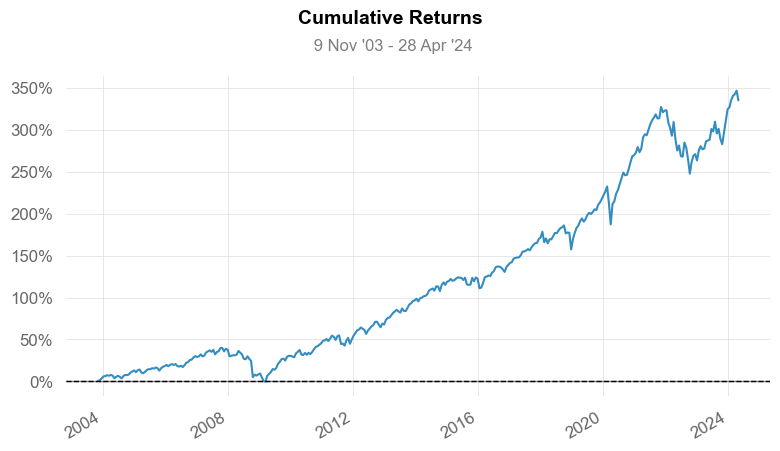

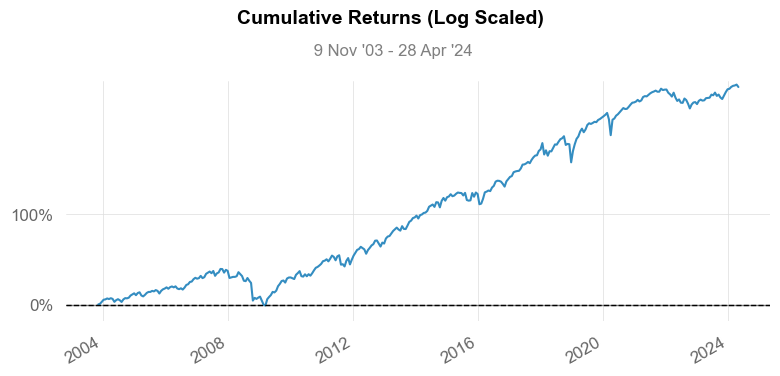

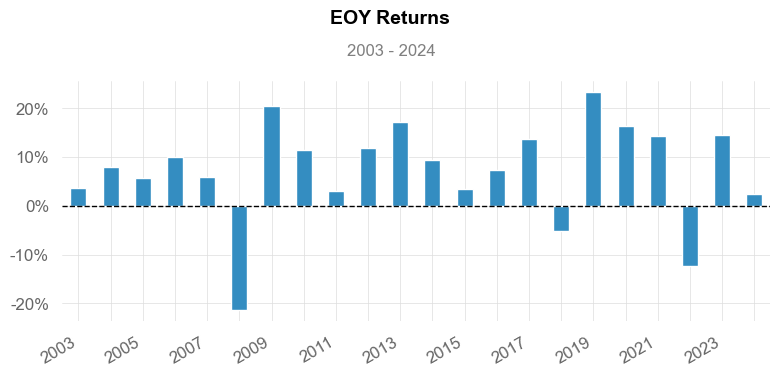

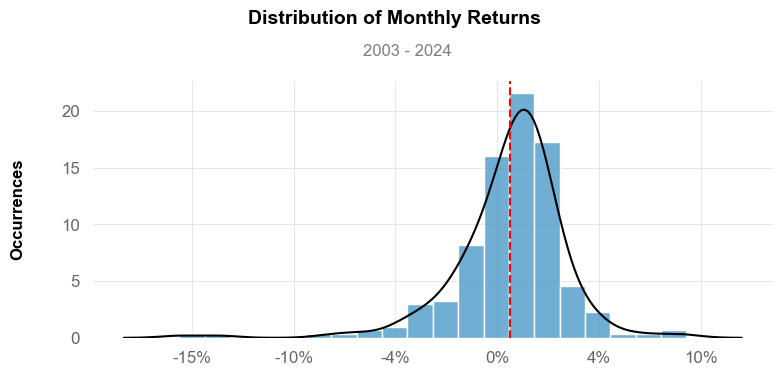

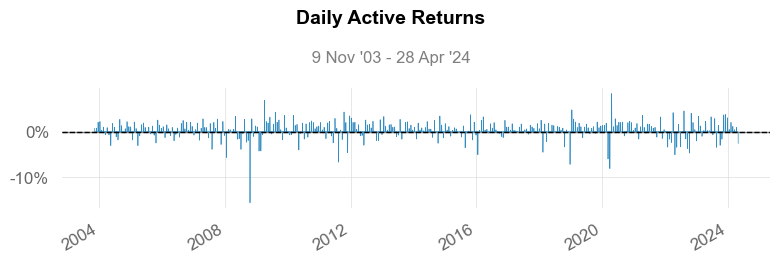

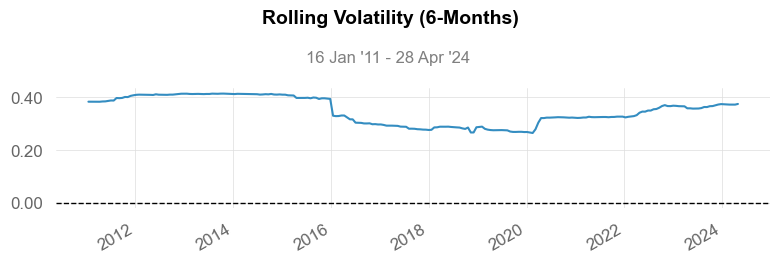

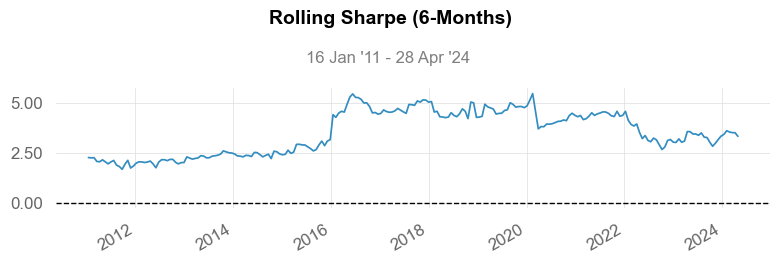

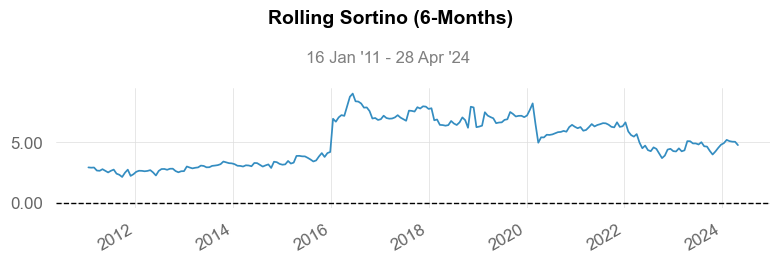

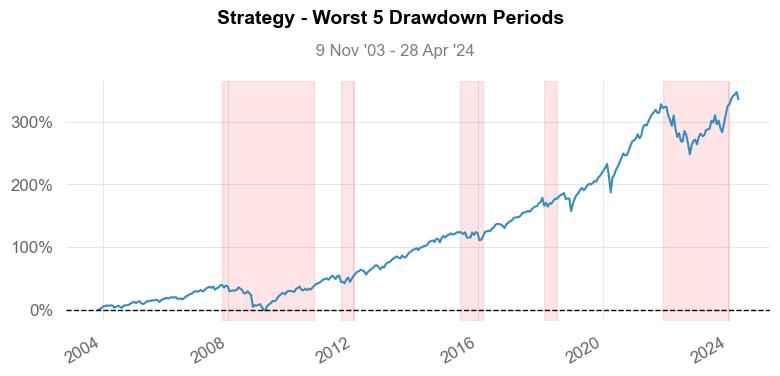

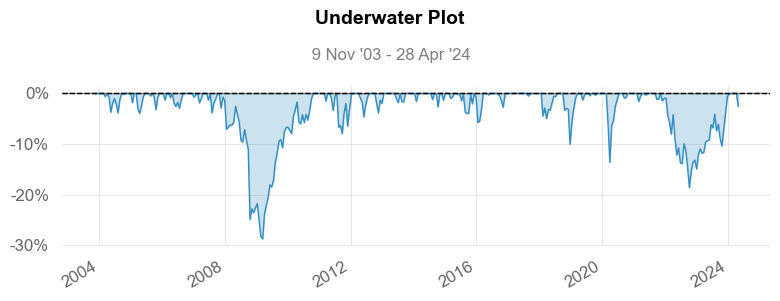

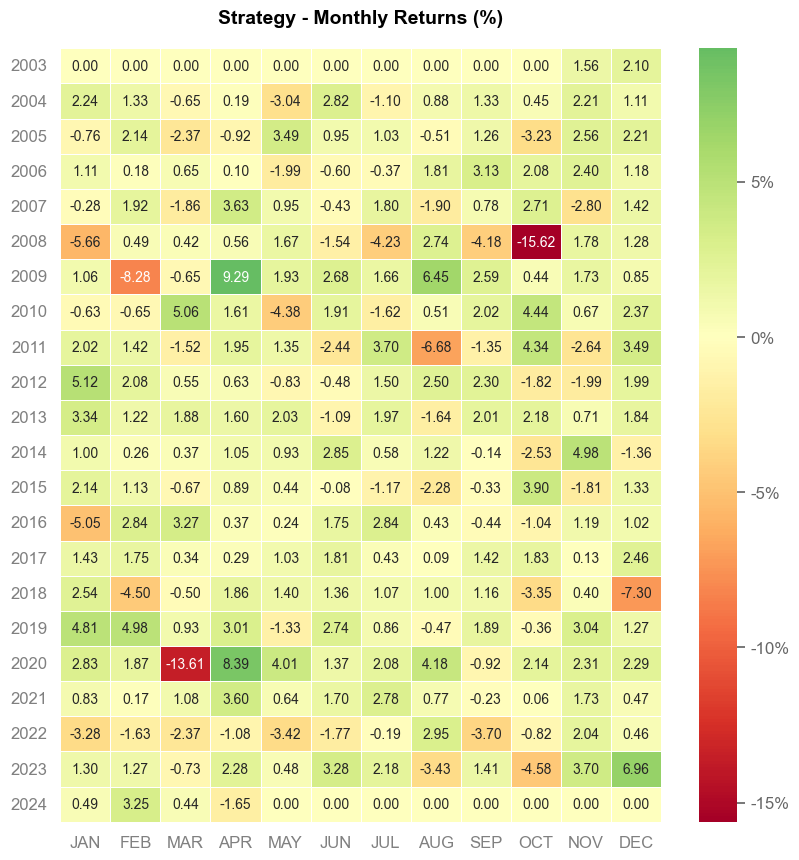

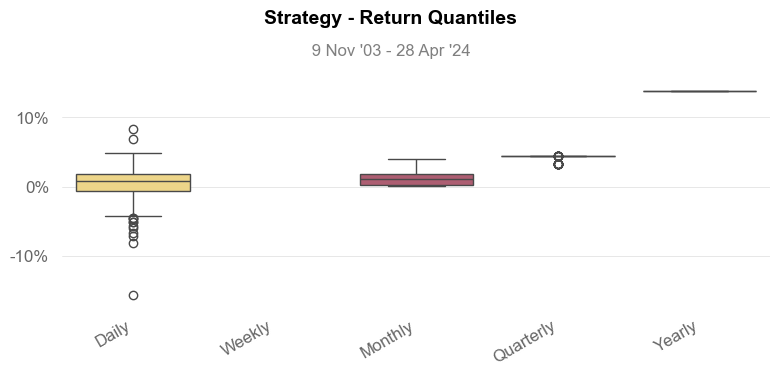

In [ ]:
#%%

qs.reports.full(portfolio_df['adjusted_ret'])